## IMPORTING LIBRARIES

In [1]:
!pip install gdown

In [2]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import random
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

## PRE-DEFINE MATPLOTLIB CHART SETUPS

In [3]:
plt.rcParams['figure.figsize'] = [14, 6]
sns.set(style="whitegrid")

## IMPORTING DATA

In [4]:
DATA_SOURCE = "https://drive.google.com/uc?id="

In [5]:
url_orders = DATA_SOURCE + "1Mb1BvHirYGVbsKiddfJR6uaRrBQt4KwU"
url_order_products_prior = DATA_SOURCE + "1M8fuFMODgT_6K_XeTzR2Upg3fDPbKN66"

orders_file = "orders.csv"
order_products_prior_file = "order_products_prior.csv"

gdown.download(url_orders, orders_file, quiet=False)
gdown.download(url_order_products_prior, order_products_prior_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Mb1BvHirYGVbsKiddfJR6uaRrBQt4KwU
From (redirected): https://drive.google.com/uc?id=1Mb1BvHirYGVbsKiddfJR6uaRrBQt4KwU&confirm=t&uuid=f7ca8204-7781-4044-8328-5dbef7c9910c
To: /Users/mac/Desktop/DSTI_Project/Project/model/orders.csv
100%|████████████████████████████████████████| 109M/109M [00:02<00:00, 40.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1M8fuFMODgT_6K_XeTzR2Upg3fDPbKN66
From (redirected): https://drive.google.com/uc?id=1M8fuFMODgT_6K_XeTzR2Upg3fDPbKN66&confirm=t&uuid=ef2dbb87-1a42-4743-b64b-46a128eff3cb
To: /Users/mac/Desktop/DSTI_Project/Project/model/order_products_prior.csv
100%|████████████████████████████████████████| 578M/578M [00:07<00:00, 80.3MB/s]


'order_products_prior.csv'

In [6]:
order_products_train = pd.read_csv(DATA_SOURCE + "1Egfno5jVrQXCkrhEgdPrQR2akqs7U5fJ")
products = pd.read_csv(DATA_SOURCE + "18weuttpH8e1NaHDWINx6etGFj92R0_50")
departments = pd.read_csv(DATA_SOURCE + "1mBix_Zbg67I1foEsljFm7Cf23H_SFhcI")
aisles = pd.read_csv(DATA_SOURCE + "1BnskfcHBFUTTvj0d1FMoErTw99eOx-bE")
orders = pd.read_csv(orders_file)
order_products_prior = pd.read_csv(order_products_prior_file)

## INPUT DATA

In [7]:
max_len = 3
product_frequency = 200
min_threshold = 1.5
list_aisle = ['prepared soups salads', 'specialty cheeses', 'energy granola bars']
list_department = []

## EXPLORATORY DATA ANALYSIS

### Check if order_products_prior has the same data with order_products_train or not

In [8]:
df_check = order_products_prior.merge(order_products_train, on = "order_id", how = "inner")

In [9]:
df_check.head()

,order_id,product_id_x,add_to_cart_order_x,reordered_x,product_id_y,add_to_cart_order_y,reordered_y


In [10]:
# df_check returns nothing, so there is no any duplicate "order_id" data in order_products_prior and order_products_train

## MERGE ALL THE TABLES TOGETHER

In [11]:
order_products = pd.concat([order_products_train, order_products_prior])

In [12]:
data = order_products.merge(products, on = "product_id", how = "left")

In [13]:
data = data.merge(aisles, on = "aisle_id", how = "left")

In [14]:
data = data.merge(departments, on = "department_id", how = "left")

In [15]:
data = data.merge(orders, on = "order_id", how = "left")

In [16]:
data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


In [17]:
data.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.174104e+07
mean,1.710566e+06,2.557551e+04,8.367738e+00,5.900617e-01,7.121799e+01,9.918544e+00,1.029444e+05,1.713998e+01,2.737285e+00,1.343123e+01,1.136415e+01
std,9.874008e+05,1.409770e+04,7.139540e+00,4.918220e-01,3.819898e+01,6.281655e+00,5.946733e+04,1.749829e+01,2.093296e+00,4.246149e+00,8.940500e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.554130e+05,1.351900e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00,5.143500e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00
50%,1.710660e+06,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00,1.026260e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00
75%,2.565587e+06,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01,1.544120e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


## CHECK TOTAL ORDER BY EACH USER

In [18]:
df_total_order = (
    data.groupby("user_id")["order_number"]
    .max()
    .reset_index(name="total_order")
)

In [19]:
df_total_order.describe()

,user_id,total_order
count,206209.000000,206209.000000
mean,103105.000000,16.226658
std,59527.555167,16.662238
min,1.000000,3.000000
25%,51553.000000,6.000000
50%,103105.000000,10.000000
75%,154657.000000,20.000000
max,206209.000000,100.000000


In [20]:
# [Observation]: 
# 1. The majority of user made from 6-20 orders
# 2. The total order by user is imbalanced

## CHECK THE NUMBER OF PRODUCT THAT ARE ORDERED BY EACH USER

In [21]:
# Get the number of ordered products by each user

In [22]:
data_number_of_ordered_products_by_user = (
    data.groupby("user_id")["product_id"]
    .size()
    .reset_index(name="Total_Products")
)

In [23]:
data_number_of_ordered_products_by_user.describe()

,user_id,Total_Products
count,206209.000000,206209.000000
mean,103105.000000,164.004025
std,59527.555167,206.014923
min,1.000000,3.000000
25%,51553.000000,44.000000
50%,103105.000000,90.000000
75%,154657.000000,196.000000
max,206209.000000,3725.000000


In [24]:
# Get the number of unique products that is ordered by users

In [25]:
data_nunique_ordered_products_by_user = (
    data.groupby("user_id")["product_id"]
    .nunique()
    .reset_index(name="Total_Products")
)

In [26]:
data_nunique_ordered_products_by_user.describe()

,user_id,Total_Products
count,206209.000000,206209.000000
mean,103105.000000,67.231527
std,59527.555167,56.876842
min,1.000000,1.000000
25%,51553.000000,28.000000
50%,103105.000000,51.000000
75%,154657.000000,89.000000
max,206209.000000,728.000000


In [27]:
data_nunique_ordered_products_by_user.head()

,user_id,Total_Products
0,1,19
1,2,121
2,3,33
3,4,17
4,5,28


In [28]:
# [Observation]: 
# 1. The number of ordered products is much more higher than the number of unique ordered products by each user.

# [Insights]
#1. Users tend to buy a certain kinds of product repetively.

## CHECK TOTAL ORDERS DISTRIBUTION BY DAYS OF WEEK

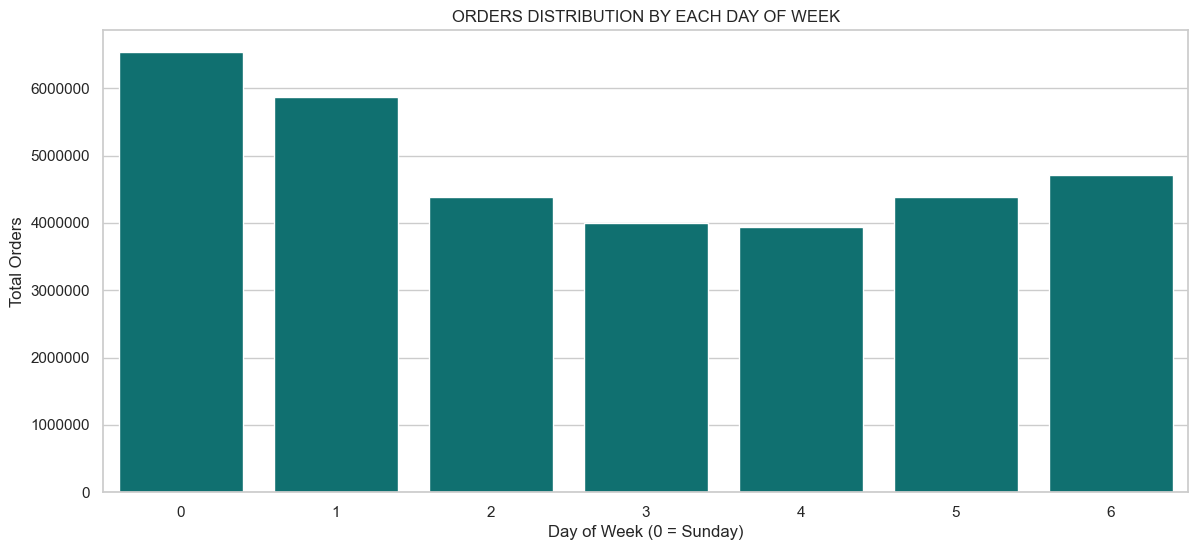

In [29]:
sns.countplot(x='order_dow', data = data, color='teal')
plt.title('ORDERS DISTRIBUTION BY EACH DAY OF WEEK')
plt.xlabel('Day of Week (0 = Sunday)')
plt.ylabel('Total Orders')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [30]:
# [Observation]: 
# 1. Users tend to order the most on the weekend (Saturday, Sunday) + Monday
# 2. Users order less on Wednesday and Thursday

# [Insights]
# 1. During the weekend, users do not need to work, so they have more free time to go shopping online 
# 2. Users often have party or do more activities on the week-end, so they need to order more than normally
# 3. Because there are a lot of activities to do on the week-end, so the products are out-of-stock quickly,
# so they need to restock again on Monday.
# 4. On Wednesday and Thursday, users have to work, so they do not have time to go shopping online
# 5. There are less activities on Wednesday and Thursday normally

# [Possible Solutions]
# 1. Implement sales promotion programs (buy 1 get 1 / discount 20%) to clear inventory on Wednesday and Thursday.
# 2. Creating products combo to push the order value or freeshipping for a certain 
# value of order (ex: free-ship for order greater than 400 euros) on the week-end.
# 3. 

## CHECK ORDER DISTRIBUTION BY BUSINESS HOURS

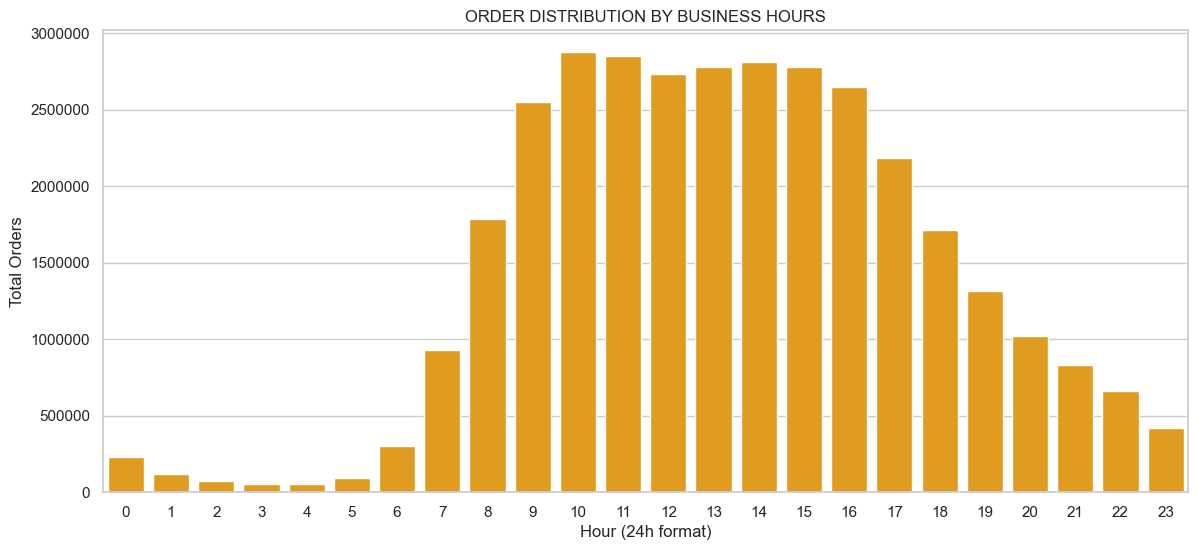

In [31]:
# 2. Orders by Hour of Day
sns.countplot(x='order_hour_of_day', data=data, color='orange')
plt.title('ORDER DISTRIBUTION BY BUSINESS HOURS')
plt.xlabel('Hour (24h format)')
plt.ylabel('Total Orders')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [32]:
# [Observation]: 
# 1. Users tend to order the most from 8h a.m to 18h p.m

# [Insights]
# 1. From 8h a.m to 18h p.m is the time for daily activities, so users make order the most on this time.
# 2. Most of supermarkets open this time, so users have more choice to choose and order products.
# 3. From 8h a.m to 18h p.m, maybe there are more shippers, so the shipping fee is cheaper.
# 4. From 18h p.m to 23h p.m, maybe some supermarkets close, so users have less choices to order.
# 5. From 18h p.m to 23h p.m, maybe there are less shippers, so the shipping fee is more expensive. 
# 6. From 0 a.m to 6 p.m is the time for sleeping, if users make orders this time, it could be someone
# who works on a different timezone, who has night party, who have some unpredictable urgencies.

# [Possible Solutions]
# 1. Having free-shipping discount for high value orders from 18h p.m to 23h p.m to push sale up.
# 2. 

## CHECK ORDERS AND PRODUCTS DISTRIBUTION BY AISLE

### ORDER DISTRIBUTION BY AISLE (TOP 20 FREQUENCIES)

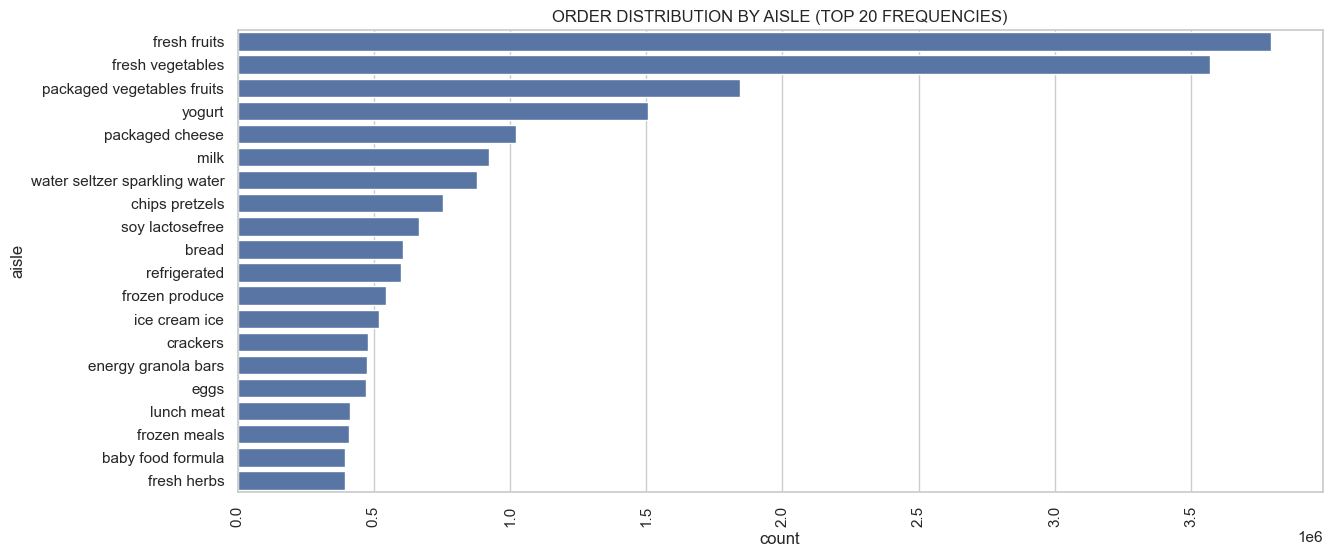

In [33]:
sns.countplot(data.aisle, order=data.aisle.value_counts().index[:20])
plt.title('ORDER DISTRIBUTION BY AISLE (TOP 20 FREQUENCIES)')
plt.xticks(rotation=90)
plt.show()

In [34]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain aisles that receives more orders than the others.

# [Insights]
# 1. Maybe there are some certain aisles that include more products than the others
# 2. People tend to buy repetively a certain kind of products

# [Possible Solutions]


### PRODUCTS DISTRIBUTION BY AISLE (TOP 20 THE MOST)

In [35]:
data_by_aisle = (
    data.groupby("aisle")["product_id"]
    .nunique()
    .reset_index(name="Total_Products")
)

In [36]:
df_top_20_aisle = data_by_aisle.sort_values("Total_Products", ascending=False).head(20)

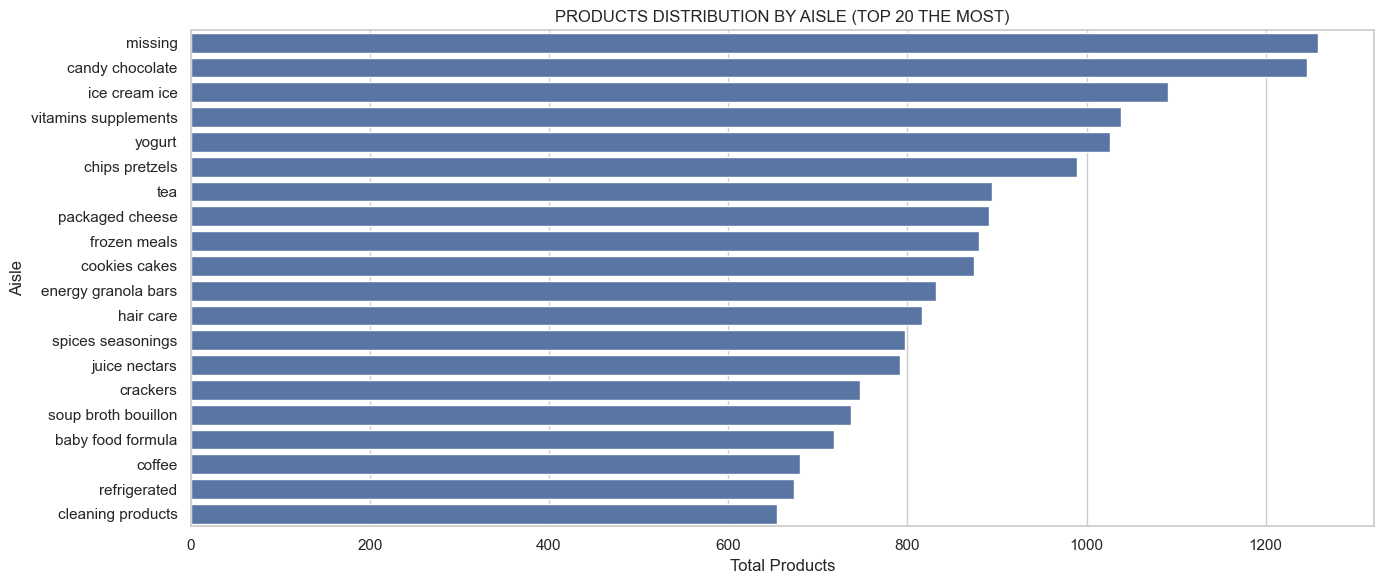

In [37]:
sns.barplot(
    data=df_top_20_aisle,
    x="Total_Products",
    y="aisle"
)
plt.title("PRODUCTS DISTRIBUTION BY AISLE (TOP 20 THE MOST)")
plt.xlabel("Total Products")
plt.ylabel("Aisle")
plt.tight_layout()
plt.show()

In [38]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain aisles that have more products than the others.

# [Insights]
# 1. 

# [Possible Solutions]


## CHECK ORDERS AND PRODUCTS DISTRIBUTION BY DEPARTMENT

### ORDERS DISTRIBUTION BY DEPARTMENT

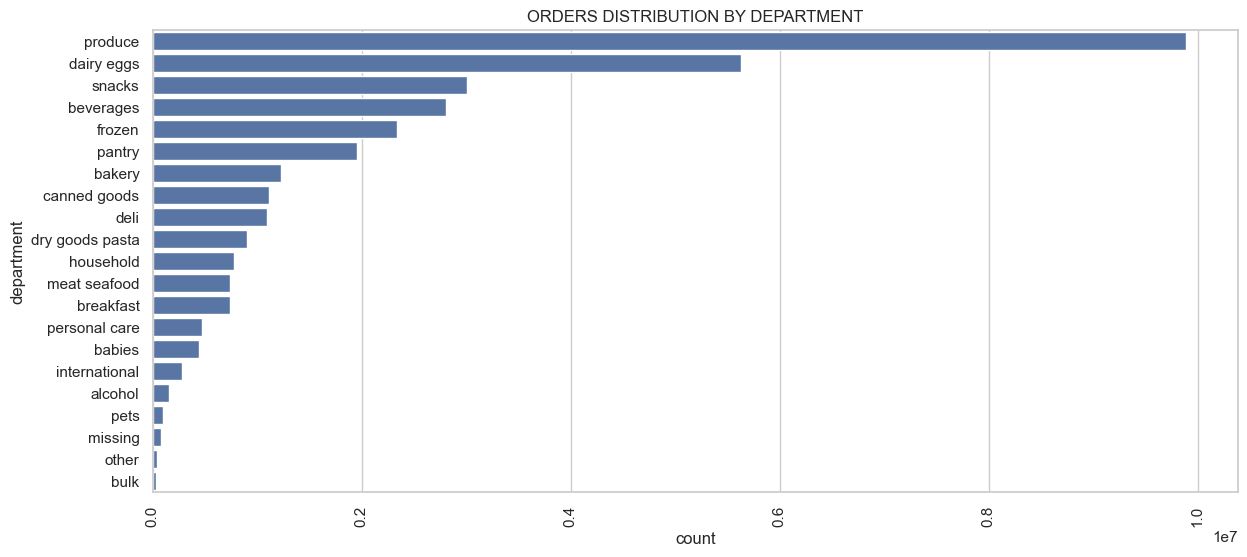

In [39]:
sns.countplot(data.department, order=data.department.value_counts().index)
plt.title('ORDERS DISTRIBUTION BY DEPARTMENT')
plt.xticks(rotation=90)
plt.show()

In [40]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain departments that have more orders than the others.

# [Insights]
# 1. Maybe there are some certain departments that include more products than the others
# 2. People tend to buy repetively a certain kind of products

# [Possible Solutions]


### PRODUCTS DISTRIBUTION BY DEPARTMENT

In [41]:
data_by_department = (
    data.groupby("department")["product_id"]
    .nunique()
    .reset_index(name="Total_Products")
)

In [42]:
data_by_department = data_by_department.sort_values("Total_Products", ascending=False)

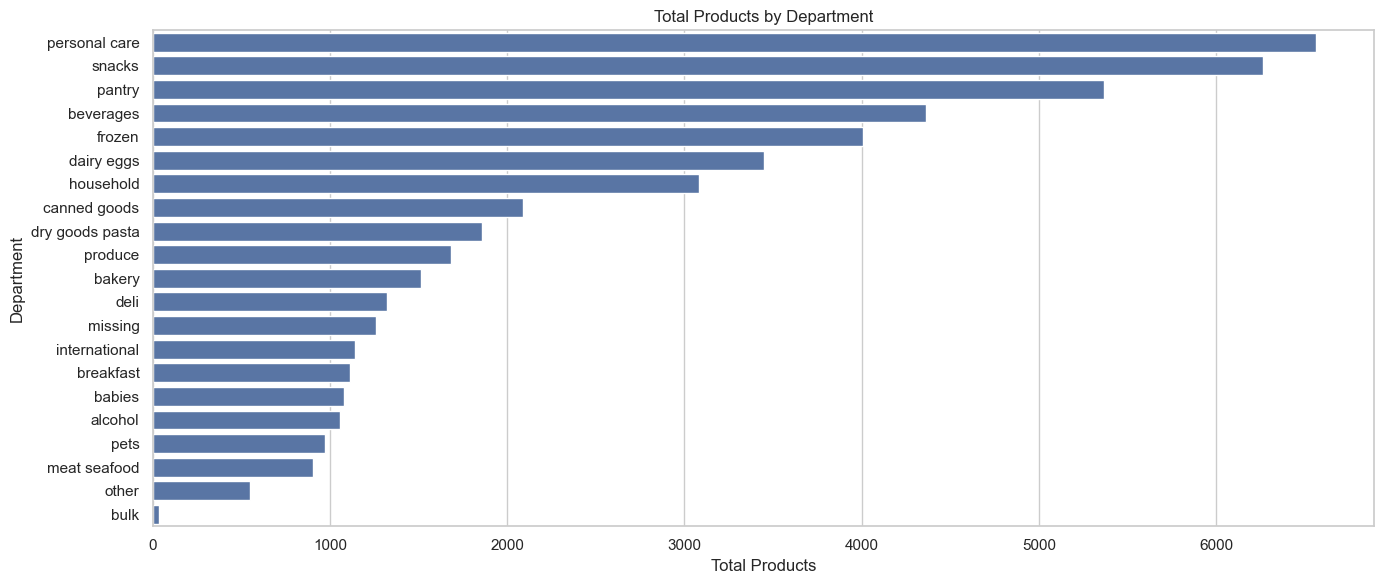

In [43]:
sns.barplot(
    data=data_by_department,
    x="Total_Products",
    y="department"
)
plt.title("Total Products by Department")
plt.xlabel("Total Products")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

In [44]:
# [Observation]: 
# 1. The data is imbalanced: there are some certain departments that have more products than the others.

# [Insights]
# 1. 

# [Possible Solutions]
# 1. If we want to push the sale up for the less productive department/aisle, we need to have more products for that.

## CHECK THE RELATIONSHIP BETWEEN AISLE AND DEPARTMENT

### NUMBER OF AISLE BY DEPARTMENT

In [45]:
data_aisle_by_department = (
    data.groupby("department")["aisle_id"]
    .nunique()
    .reset_index(name="Total_Aisles")
)

In [46]:
data_aisle_by_department = data_aisle_by_department.sort_values("Total_Aisles", ascending=False)

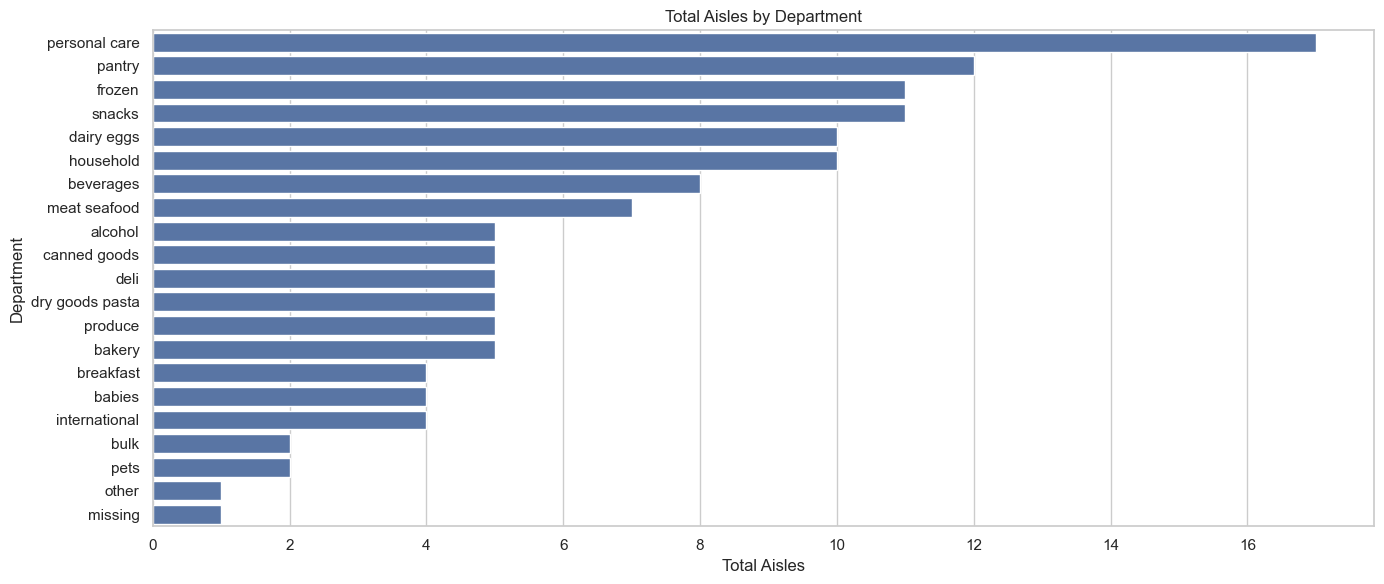

In [47]:
sns.barplot(
    data=data_aisle_by_department,
    x="Total_Aisles",
    y="department"
)
plt.title("Total Aisles by Department")
plt.xlabel("Total Aisles")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

In [48]:
# [Observation]: 
# 1. Personal Care, Household, Meat Seafood have a higher number of Aisle than the average, but they are
# ordered by users less than the average.

# [Insights]
# 1. 

# [Possible Solutions]


## IMPLEMENTING SOLUTION

### REMOVING DUPLICATES TO AVOID THE POSSIBLE BIAS

In [49]:
data = data.drop_duplicates(subset=["user_id","product_id"])

In [50]:
data.describe()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.270842e+07
mean,1.414642e+06,2.551068e+04,9.227778e+00,2.833077e-01,7.104573e+01,1.021869e+01,1.030158e+05,1.369867e+01,2.752587e+00,1.353347e+01,1.299403e+01
std,9.972372e+05,1.422548e+04,7.535828e+00,4.506046e-01,3.805440e+01,6.211893e+00,5.943946e+04,1.541768e+01,2.105470e+00,4.225757e+00,9.734872e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.211650e+05,1.329200e+04,4.000000e+00,0.000000e+00,3.200000e+01,4.000000e+00,5.160325e+04,4.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00
50%,1.268210e+06,2.563800e+04,7.000000e+00,0.000000e+00,8.100000e+01,1.100000e+01,1.027330e+05,8.000000e+00,3.000000e+00,1.300000e+01,9.000000e+00
75%,2.233561e+06,3.815400e+04,1.300000e+01,1.000000e+00,1.060000e+02,1.600000e+01,1.544780e+05,1.800000e+01,5.000000e+00,1.600000e+01,2.000000e+01
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [52]:
if len(list_department) > 0:
    data = data[data['department'].isin(list_department)]
elif len(list_aisle) > 0:
    data = data[data['aisle'].isin(list_aisle)]
else:
    data = data

In [53]:
# only need order_id and product_name for discovering

In [54]:
data_explore = data[['order_id', 'product_name']]

## CALCULATING SUPPORT POINT

In [55]:
total_order = data_explore["order_id"].nunique()
support_point = product_frequency/total_order

In [56]:
#convert dataframe to list type

In [57]:
basket = data_explore.groupby('order_id')['product_name'].apply(list).tolist()

## TRAINSACITON ENCODING DATA

In [58]:
te = TransactionEncoder()
te_ary = te.fit(basket).transform(basket)
df = pd.DataFrame(te_ary, columns=te.columns_)

## PROCESSING THE DATA

In [59]:
frequent_itemsets = fpgrowth(df, min_support = support_point, use_colnames=True, max_len = max_len)

In [60]:
frequent_itemsets.head()

,support,itemsets
0,0.005367,(Chewy 25% Low Sugar Chocolate Chip Granola)
1,0.002639,(Grated Pecorino Romano Cheese)
2,0.002049,(Kid Z Bar Organic Honey Graham Energy Snack)
3,0.006731,(Plus Cranberry Almond + Antioxidants with Mac...
4,0.006105,(Chewy Granola Bars Variety Pack)


In [61]:
rules = association_rules(
    frequent_itemsets,
    metric = "lift",
    min_threshold = min_threshold
)

In [62]:
rules = rules.sort_values(by = ["lift", "support"], ascending=False)

In [63]:
rules = rules[["antecedents", "consequents", "support", "confidence", "lift"]]

In [64]:
rules = rules.drop_duplicates(subset=["support"])

## OUTPUT DATA

In [65]:
# return top 20 strong relationship product bundles

In [66]:
rules.head(20)

,antecedents,consequents,support,confidence,lift
114,(Organic Turmeric Ginger & Beet Superfoods Bar),(Coconut Kale & Cacao Organic Superfoods Bar),0.001243,0.420677,130.291259
92,(Organic Hazelnut Hemp Cacao Superfoods Bar),(Coconut Kale & Cacao Organic Superfoods Bar),0.001138,0.406015,125.750077
94,(Apple & Apricot Fruit Bar),(1 Apple + 1 Pear Fruit Bar),0.001053,0.312500,88.685071
86,"(Acai Berry Chia Bar, Chocolate Peanut Butter)",(Coconut Chia Bar),0.001670,0.636546,55.209113
80,(Peanut Butter Egg White Protein Bar),(Coffee Chocolate Bar),0.001143,0.180683,40.500458
100,(Coconut Chocolate Bar),(Chocolate Sea Salt),0.003229,0.386263,37.396639
82,(Acai Berry Chia Bar),(Coconut Chia Bar),0.003023,0.412356,35.764611
78,(Coconut Chocolate Bar),(Coffee Chocolate Bar),0.001317,0.157530,35.310697
74,(Chocolate Peanut Butter),(Coconut Chia Bar),0.004825,0.392964,34.082705
76,(Coffee Chocolate Bar),(Chocolate Sea Salt),0.001527,0.342385,33.148479
